# Training and Running of new GLM model
This Notebook is for training and running the our new GLM model that includes (for now only) deletion tokens

## Adding necessary imports
You can run this block to import necessary classes and functions

/home/giokepa/.virtualenvs/Sysgen-GLM-for-Indels/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initializing fresh model (include_deletions=True)
No trained model loaded. Call train() to train the model.
Checking for existing trained model in ./dna_bert_final_baseline
Loading tokenizer...
Tokenizer loaded
Loading dataset...
Dataset loaded
Loading model...
Model loaded successfully!
Model type: Baseline (no deletions)
Trained for 500 epochs
Final validation loss: 1.9356
Training curves saved to ./dna_bert_final_baseline/training_curves_replotted.png


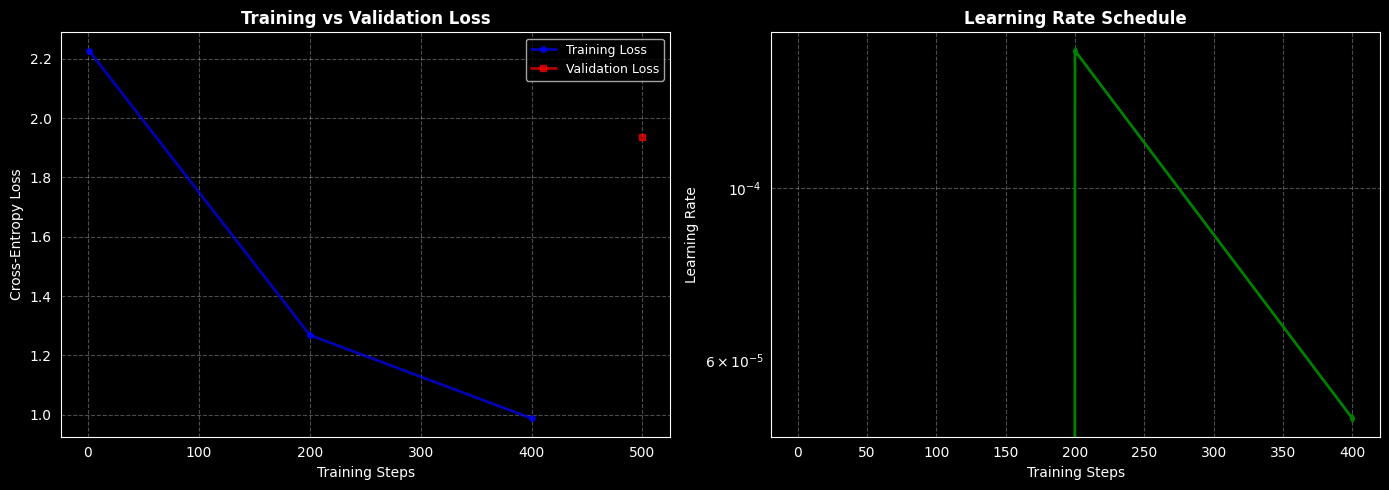


Training Summary:
Final training loss: 0.9880
Final validation loss: 1.9356
Best validation loss: 1.9356


In [1]:
from fundemental_classes.model_related.glm_model import GLMModel

# You can change force_retrain to True if you want to always retrain your model everytime
deletion_model = GLMModel("./dna_bert_final_indel",
                          "simulated_sequences_distance=5/new_augumented_sequence_size10000_length150_deletions0.2_nodeletionseq0.05.fasta",
                          force_retrain=False, include_deletions=True)
baseline_model = GLMModel("./dna_bert_final_baseline",
                           "simulated_baseline_sequences_distance=5/new_augumented_sequence_size10000_length150_deletions0_nodeletionseq0.05.fasta",
                           force_retrain=False, include_deletions=False)

# Set the default Model to train and use for visualization
model = baseline_model
use_deletions = False


## Training
We use `Bert` model to create the embeddings and train it using masking to get nicely trained model. If you want to change the size of training data, please look into `simulated_sequences` directory. \\\

Below is given two subheaders: *Baseline Model Training & Deletion Model Training*. Each of them can be run seperately if you are looking for seperate results or loading.
*important:* Training is not necessary if you already have a trained model. You can load it using the `GLMModel`.

### Baseline Model Training

In [ ]:
baseline_model.train(epochs=500, batch_size=32, lr=2e-4)

### Deletion Model Training

In [ ]:
deletion_model.train(epochs=500, batch_size=32, lr=2e-4)


## Visualization | Sequence reconstruction probabilities
This block is used for getting already trained model, passing the sequence to test how well the model performs.
\\\\\
*Important:* For now we pass our test cases by hand. However in the future we will generate good inputs to test how well the model functions

### OLD SEQUENCE PLOTTER

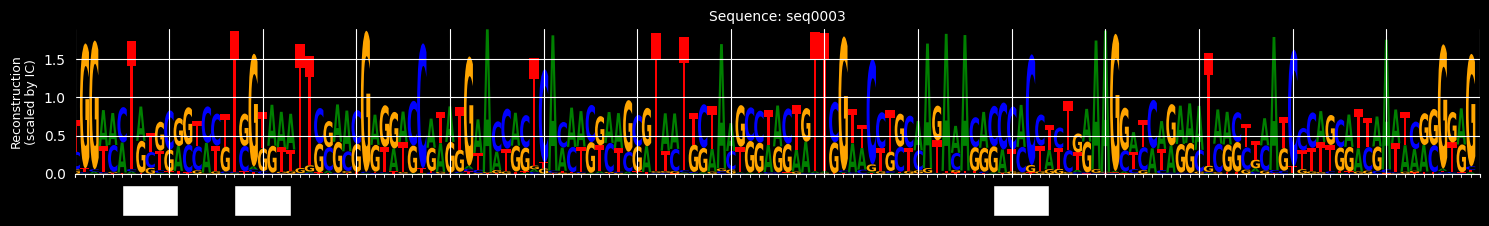

In [2]:
from fundemental_classes.visualization.sequence_plotter import plot

#normal reconstruction
header = ">seq0003|label=both|posAmotif=5,98|posBmotif=17|gaplength=5|deletions=0"
sequence = "GGTCGATATTCATTCCTGTACTGCTTGATCCACTACCATGTACTTCAATCCTGGCGATGTCTAGTCTCACAGGGAGGTACATATGGTGCAACATTGGAATATTCAACAGGGTATAGGCCTAGACGAGGCATATAAAGCCTGACAACATGT"

prob_matrix = model.get_full_reconstruction_probs(sequence)

plot(header, sequence, prob_matrix, motif_length=6, with_deletions=use_deletions)

### NEW SEQUENCE PLOTTER

In [ ]:
from fundemental_classes.visualization.sequence_plotter_new import plot

#normal reconstruction
header = "seq0003|label=both|posAmotif=15,58|posBmotif=28|gaplength=5|deletions=6"
sequence = "GG-CCATCTTAGACCATATTCA-CCGCCGTACTGCATGAAG-CTGACGGAGTATGACAATATTCATCACCAGGACACGATCACGCTA-GTACTCAGCGGGCT-CTTCCTTGG-AGGAAGAGGGCCACTACCGGAACCGTTATTAATACGGATTCTT"

prob_matrix = model.get_full_reconstruction_probs(sequence)

plot(header, sequence, prob_matrix, motif_length=6, with_deletions=use_deletions)

In [ ]:
#replace with letter (SNP variation)
header = "seq0030|label=both|posAmotif=13|posBmotif=140|gaplength=100|deletions=27"
sequence = "A-TTGGAGC-CCAATATTCA--CGCCTC-A-CC-A-ACTCG-AGGTTC--GGAAT-TCCCC-T-TCCCAGCCTTG-AGTC--AATTGGGG-TCCTGCTGA-TACAATGG--CT-GCTGTGGACGACTCCTATGATGGGCTGTACTGC--GA-G-GCTTCGGTAGAAT-CGTTATGCC"

prob_matrix = model.get_full_reconstruction_probs(sequence)

plot(header, sequence, prob_matrix, motif_length=6, with_deletions=use_deletions)

In [ ]:
#replace with deletion token (InDel variation)
header = "seq0030|label=both|posAmotif=13|posBmotif=140|gaplength=100|deletions=27"
sequence = "A-TTGGAGC-CCAATATTCA--CGCCTC-A-CC-A-ACTCG-AGGTTC--GGAAT-TCCCC-T-TCCCA-CCTTG-AGTC--AATTGGGG-TCCTGCTGA-TACAATGG--CT-GCTGTGGACGACTCCTATGATGGGCTGTACTGC--GA-G-GCTTCGGTAGAAT-CGTTATGCC"

prob_matrix = model.get_full_reconstruction_probs(sequence)

plot(header, sequence, prob_matrix, motif_length=6, with_deletions=use_deletions)

## Visualization | Dependency Map
This block is used for getting already trained model, passing the sequence to test how well the model performs.
\\\\\

In [ ]:
from fundemental_classes.visualization.heat_map_plotter import DependencyMapGenerator
import numpy as np
import plotly.graph_objects as go
from fundemental_classes.visualization.sequence_logo import SequenceLogo


# a function for creating the heatmap with overlayed logo with input sequence, type of dependency and model
def depencency_map_with_logo(model, sequence, type='snp'):
    dep_gen = DependencyMapGenerator(model, type=type, use_deletions=use_deletions)
    prob_matrix = model.get_full_reconstruction_probs(sequence)
    dep_map = dep_gen.analyze(sequence, show_plot=False)
    L = dep_map.shape[0]
    reconstruction_logo = SequenceLogo.from_reconstruction(prob_matrix)
    fig = go.Figure()
    fig.add_trace(
        go.Heatmap(
            z=dep_map,
            x=np.arange(L),
            y=np.arange(L),
            colorscale="RdBu_r",
        )
    )
    # if the xaxes and yaxes are shown
    fig.update_xaxes(visible=True, scaleanchor="y", constrain="domain")
    fig.update_yaxes(visible=True, autorange="reversed", scaleanchor="x", constrain="domain")
    # Overlay logo at the top 
    fig.add_layout_image(
        source=reconstruction_logo.to_svg(data_url=True),
        xref="x",
        yref="y domain",
        x=-0.5,  # align left edge of first column
        y=1.0,  # top of heatmap domain
        sizex=L,  # span exactly L columns
        sizey=0.10,  # height in domain units (tune)
        xanchor="left",
        yanchor="bottom",
        sizing="stretch",
    )
    fig.update_layout(
        width=900,
        height=900,
        margin=dict(l=20, r=20, t=100, b=20),
    )
    fig.show()


In [ ]:
#dependency map for snp 
header = "seq0004|label=both|posAmotif=22,44,85|posBmotif=35,57|gaplength=5|deletions=9"
sequence = "CAGTTTA-TTCTTACCCCCCTAATATTCACGCG-GGTACTGC-CATATTCACCA-GCGTACTGCTTTAC-GGAGACTA-TCTGTAATATTCATAATACGGCTATAACAACAATTTGATGGC-AGCAGGAGAGCAGACCAAAAGTG-GG-TGTTAAGTCA"
dep_map = depencency_map_with_logo(model, sequence, type='snp')

In [ ]:
#dependency map for indels - reconstruction

header = "seq0004|label=both|posAmotif=22,44,85|posBmotif=35,57|gaplength=5|deletions=9"
sequence = "CAGTTTA-TTCTTACCCCCCTAATATTCACGCG-GGTACTGC-CATATTCACCA-GCGTACTGCTTTAC-GGAGACTA-TCTGTAATATTCATAATACGGCTATAACAACAATTTGATGGC-AGCAGGAGAGCAGACCAAAAGTG-GG-TGTTAAGTCA"

dep_map = depencency_map_with_logo(model, sequence, type='indel')

In [ ]:
#dependency map for indels - replacement

header = "seq0030|label=both|posAmotif=13|posBmotif=140|gaplength=100|deletions=27"
sequence = "A-TTGGAGC-CCAATATTCA--CGCCTC-A-CC-A-ACTCG-AGGTTC--GGAAT-TCCCC-T-TCCCA---TTG-AGTC--AATTGGGG-TCCTGCTGA-TACAATGG--CT-GCTGTGGACGACTCCTATGATGGGCTGTACTGC--GA-G-GCTTCGGTAGAAT-CGTTATGCC"

dep_map = depencency_map_with_logo(model, sequence, type='indel')

In [ ]:
#dependency map for indels - removal

header = "seq0004|label=both|posAmotif=22,44,85|posBmotif=35,57|gaplength=5|deletions=9"
sequence = "CAGTTTA-TTCTTACCCCCCTAATATTCACGCG-GGTACTGC-CATATTCACCA-GCGTACTGCTTTAC-GGAGACTA-TCTGTAATATTCATAATACGGCTATAACAACAATTTGATGGC-AGCAGGAGAGCAGACCAAAAGTG-GG-TGTTAAGTCA"

dep_map = depencency_map_with_logo(model, sequence, type='indel')